In [1]:
import os
os.environ["THEANO_FLAGS"] = "device=cpu,floatX=float32"
import theano
import theano.tensor as T
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3.backends.base import merge_traces
import matplotlib.pyplot as plt
%matplotlib inline
import time
import dill

import tribe_010218 as model
import simulator as simulator

**Goal**: Walk through an application of the time-variant annotator model on demo data and explain the key functions involved.

#### Contents 

1. <a href='#setup'>setup</a>
2. <a href='#model'>model</a>
3. <a href='#results'>results</a>



<a id='setup'></a>
#### 1. setup

* Some brand csvs have been simulated using **simulator.py**. `python simulator.py`


* We import, clean and prepare them for pymc3. The objective is to create `mcmc_in`, an instance of the `mcmc_input_class`. 


* `mcmc_in` lists turker responses at the post-brand-worker level. It is characterized by vectors of identifiers. `ii_transformer` is a lookup table that gets us from temporarily generated post ids back to Tribe post hashes. Similarly, `jj_transformer` and `kk_transformer` get us from temporary ids back to workers and brands respectively. These temporary ids are used to establish hierarchy in the model.


* In **tribe_010218.py**, we similarly funnel inputs into an `mcmc_in` instance. Regarding variables that appear in the Tribe csvs but aren't generated in simulation:

    * *mturker* - a few posts had already been labeled by Tribe employees. We use these posts as a validation set and treat the Tribe labels as ground truth.
    
    * *duration_seconds* - this variable was initially explored but deemed too erratic to use (e.g. duration could represent labeling time for multiple posts so that it is ambiguous which stumped the annotator).
    
    * *text* - we search the text body for the presence of hashtags. If a hashtag is present we do one of 3 things: [nothing, treat as positive brand confirmation, strengthen the prior for a positive]. Treating as positive brand confirmation yields the best results most cheaply.
    
    * *model_decision* - we optionally treat the model as an additional worker. Note that this severely slows down inference without offering a gain in accuracy. In the final configuration we ignore this variable. Note that when we did include this variable, the model identified it as the most skilled worker.

In [4]:
sim_csvs = [
    "input\\simul_brand_0.csv",
    "input\\simul_brand_1.csv",
    "input\\simul_brand_2.csv",
    "input\\simul_brand_3.csv",
]

In [5]:
sim_df, ii_transformer, jj_transformer, kk_transformer = simulator.prep_sim(sim_csvs)

In [6]:
mcmc_in = model.get_inputs(sim_df)

* check there isn't overwhelming consensus (i.e. if too much mass is at 0 and 1 then the task is easy and I recommend majority voting).

Text(0,0.5,'count items')

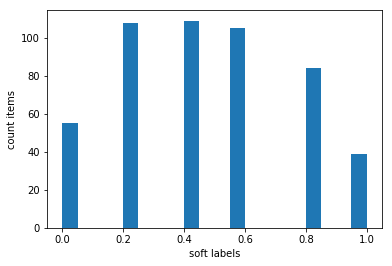

In [7]:
plt.hist(sim_df.groupby(["post_hash"]).mean()["answer"], bins=20)
plt.xlabel("soft labels")
plt.ylabel("count items")

* typically the true trajectory of annotator skill is hidden but in our simulation sandbox we can plot it.


* the simulator gives us 5 kinds of paths. A session switcher (the piecewise step w0), fatigue and practice (the sigmoids w1 and w3), linear (w2) and a spammer (the parabola w4).

In [8]:
filename = os.path.join("input", "path_df.dill")
with open(filename,'rb') as file_object:
    raw_data = file_object.read()
deserialized = dill.loads(raw_data)
path_df = pd.DataFrame(deserialized)

Text(0,0.5,'theta (annotator accuracy)')

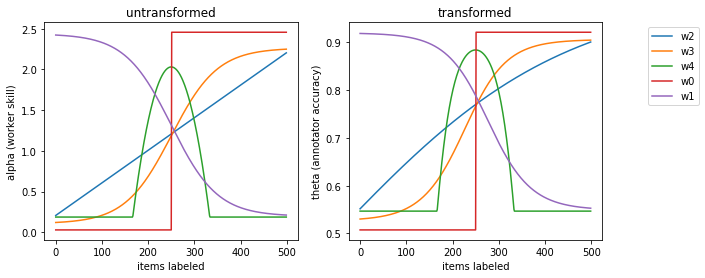

In [9]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("untransformed")
for worker_id, Nj, prob_fn in path_df[["worker_id", "Nj", "prob_fn"]].values:
    plt.plot([prob_fn(t) for t in range(Nj)], label=worker_id)
plt.xlabel("items labeled")
plt.ylabel("alpha (worker skill)")
    
plt.subplot(1,2,2)
plt.title("transformed")
for worker_id, Nj, prob_fn in path_df[["worker_id", "Nj", "prob_fn"]].values:
    plt.plot([1/(1+np.exp(-1*prob_fn(t))) for t in range(Nj)], label=worker_id)
plt.legend(bbox_to_anchor=(1.4,1))
plt.xlabel("items labeled")
plt.ylabel("theta (annotator accuracy)")

<a id='model'></a>
#### 2. model

* We fit two models. `model_evolving` allows annotator skill to be time-variant, `model_static` assumes skill is static.


* The main output of pymc3 is a trace object. It is a dictionary, with keys = names of model parameters and values = samples.

In [10]:
trace1 = model.model_evolving(mcmc_in, brand_level=True, asymmetric_accuracy=False, draws=500, tune=500)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [beta_prime, alpha_walk4, alpha_walk3, alpha_walk2, alpha_walk1, alpha_walk0, volatility, rho]
>BinaryGibbsMetropolis: [z_missing]
100%|██████████| 1000/1000 [05:40<00:00,  2.94it/s]
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [11]:
trace2 = model.model_static(mcmc_in, alpha_prior=(1,1), beta_prior=(0,1), asymmetric_accuracy=False, hashtag_treatment="none", draws=500, tune=500)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [alpha, beta_prime, rho]
>BinaryGibbsMetropolis: [z_missing]
100%|██████████| 1000/1000 [03:53<00:00,  4.29it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


<a id='results'></a>
#### 3. results

* We do a decent job at recovering the path of annotator skill (red = truth, blue = model inference).

Text(-24,1.1,'Accuracy')

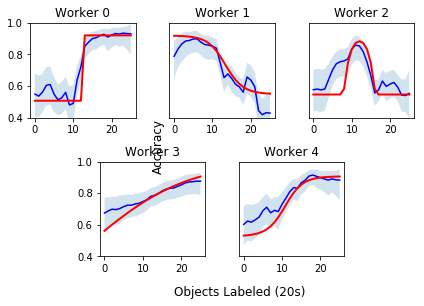

In [12]:
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

ax_list = [ax1, ax2, ax3, ax4, ax5]

interval = 20
j_len_max = max((pd.Series(mcmc_in.jj).value_counts()//interval)+1)

for j in range(mcmc_in.J):
    trange = np.array(list(range(j_len_max*interval)[::interval]))+interval//2
    ax_list[j].fill_between(x=np.arange(len(trange)), 
                    y1=np.mean(1/(1+np.exp(-1*trace1["alpha_walk"+str(j)])), axis=0) + np.std(1/(1+np.exp(-1*trace1["alpha_walk"+str(j)])), axis=0),
                    y2=np.mean(1/(1+np.exp(-1*trace1["alpha_walk"+str(j)])), axis=0) - np.std(1/(1+np.exp(-1*trace1["alpha_walk"+str(j)])), axis=0),
                    alpha=0.2,
                    lw=0
                    )
    ax_list[j].plot(1/(1+np.exp(-1*np.mean(trace1["alpha_walk"+str(j)], axis=0))), color='blue', label='model')
    prob_fn = path_df[path_df["worker_id"]==jj_transformer.index[j]]["prob_fn"].values[0]
    ax_list[j].plot([1/(1+np.exp(-1*prob_fn(t))) for t in trange], label=worker_id, color="red", lw=2)
    
    ax_list[j].set_ylim([0.4,1])
    ax_list[j].set_title("Worker "+str(j))

    if j!=0 and j!=3:
        ax_list[j].set_yticks([])
    
plt.tight_layout()
plt.text(-1, 0.15, 'Objects Labeled (20s)', ha='center', fontsize=12)
plt.text(-24, 1.1, 'Accuracy', va='center', rotation='vertical', fontsize=12)


* We conclude by comparing the accuracy of majority voting, the static and the time-variant model.


* On the demo data, we recover true labels significantly more accurately by modeling the path of annotator skill.

In [13]:
def get_predictions(trace, ii_transformer, suffix, mcmc_in):
    z_obs = mcmc_in.z_obs
    z_inferred = np.array(z_obs, dtype=float)
    z_inferred[np.where(z_obs==-999)[0]] = np.mean(trace["z_missing"], axis=0)
    pred_df = pd.DataFrame({
        "post_hash":ii_transformer.index,
        "z_inferred_"+suffix:1*(z_inferred>0.5),
        "z_obs":mcmc_in.z_obs,
        "z_soft_"+suffix:z_inferred})
    pred_df["post_hash"] = pred_df["post_hash"].astype(str)
    return pred_df


In [14]:
# calculate majority vote
pred_df = sim_df.groupby(["post_hash","hidden_z"]).mean()["r"].reset_index()
pred_df = pred_df.rename(columns={"r":"r_maj_soft"})
pred_df["r_maj"] = 1*(pred_df["r_maj_soft"]>=0.5)
pred_df["post_hash"] = pred_df["post_hash"].astype(str)

# combine predictions from all models
trace_list = [trace1, trace2] 
suffix_list = ["time-variant", "static"]
for i in range(len(trace_list)):
    pred_df = pred_df.merge(get_predictions(trace_list[i], ii_transformer, suffix_list[i], mcmc_in), on="post_hash")
    
# generate row of summary stats
row = {}
row["r_maj"] = (np.sum(pred_df[pred_df["z_obs_x"]==-999]["r_maj"]==pred_df[pred_df["z_obs_x"]==-999]["hidden_z"]) + pred_df[pred_df["z_obs_x"]!=-999].shape[0])/pred_df.shape[0]
for i in range(len(trace_list)):
    row["acc_"+suffix_list[i]] = np.mean(pred_df["z_inferred_"+suffix_list[i]]==pred_df["hidden_z"])


In [15]:
row

{'r_maj': 0.85999999999999999,
 'acc_time-variant': 0.92400000000000004,
 'acc_static': 0.81000000000000005}